In [141]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision

import random
from tqdm import tqdm

random.seed(0)
torch.manual_seed(0)


In [142]:
prepare_train_images = torchvision.transforms.Compose(
    [
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.CenterCrop(200),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
    [0.0, 0.0, 0.0] , std = [0.9, 0.5, 0.5]
    ),
    torchvision.transforms.RandomHorizontalFlip()
    ]
)

train_cars_dataset = ImageFolder('C:\\Users\\Пользователь\\Desktop\\Python_Development\\cars_classifier\\Datasets\\Train', transform=prepare_train_images)

In [19]:
train_cars_dataset[0][0].size()

torch.Size([3, 200, 200])

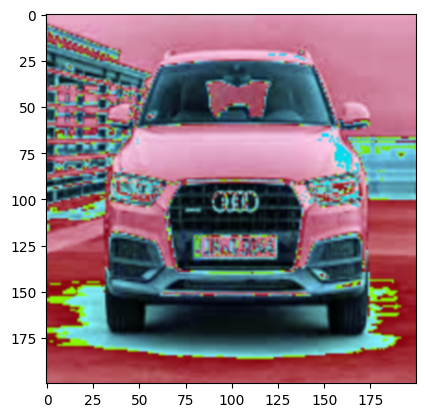

In [143]:
from PIL import Image
img = Image.fromarray(train_cars_dataset[1][0].numpy(), 'RGB')
plt.imshow(torchvision.transforms.ToPILImage()(train_cars_dataset[5][0]), interpolation="bicubic")


In [ ]:
train_cars_dataset.imgs

In [10]:
set_targets = set(train_cars_dataset.targets)
set_targets

{0, 1, 2, 3}

In [11]:
names_set = ['audi', 'bmw', 'lamba', 'mercedes']

In [12]:
dict_labels = {}
for i in range(len(set_targets)):
    dict_labels[str(i)] = names_set[i]
dict_labels

{'0': 'audi', '1': 'bmw', '2': 'lamba', '3': 'mercedes'}

In [144]:
prepare_test_images = torchvision.transforms.Compose(
    [
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.CenterCrop(200),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        [0.0, 0.0, 0.0] , std = [0.9, 0.5, 0.5]
    ),
    torchvision.transforms.RandomHorizontalFlip()
    ]
)

test_cars_dataset = ImageFolder('C:\\Users\\Пользователь\\Desktop\\Python_Development\\cars_classifier\\Datasets\\Test', transform=prepare_test_images)

In [14]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция, чтобы
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")

In [15]:
batch_size = 32

In [145]:
loaders = {'training': DataLoader(train_cars_dataset, batch_size, pin_memory=True, shuffle=True),
           'test':DataLoader(test_cars_dataset, batch_size, pin_memory=True, shuffle=False)}

In [23]:
len(loaders['training'].dataset)

209

In [26]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [27]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    optimizer: оптимизатор
    epochs: число обучающих эпох (сколько раз пройдемся по всему датасету)
    """
    loss_meter = {'training': ValueMeter(), 'test': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'test': ValueMeter()}

    loss_track = {'training': [], 'test': []}
    accuracy_track = {'training': [], 'test': []}

    for epoch in range(epochs): # итерации по эпохам
        for mode in ['training', 'test']: # обучение - валидация
            # считаем градиаент только при обучении:
            with torch.set_grad_enabled(mode == 'training'):
                # в зависимоти от фазы переводим модель в нужный ружим:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    
                    bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                    preds = model(imgs) # forward pass - прогоняем тензор с картинками через модель
                    loss = F.cross_entropy(preds, labels) # считаем функцию потерь
                    acc = accuracy(preds, labels) # считаем метрику

                    # храним loss и accuracy для батча
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # если мы в фазе обучения
                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем прошлый градиент
                        loss.backward() # делаем backward pass (считаем градиент)
                        optimizer.step() # обновляем веса
            # в конце фазы выводим значения loss и accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # сохраняем результаты по всем эпохам
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track

In [80]:
model_cars = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
            nn.ReLU()
)

In [81]:
lr = 0.01 # learning rate

In [82]:
optimizer = torch.optim.SGD(params=model_cars.parameters(), lr=lr)

In [ ]:
loss_track, accuracy_track = trainval(model_cars, loaders, optimizer, epochs=2)

In [28]:
from torchvision.models import resnet50, vgg16, alexnet

In [146]:
resnet = resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)

In [ ]:
resnet.layer4.requires_grad_

In [151]:
def set_parameter_requires_grad(model):
  """
  Функция для заморозки весов модели
  """
  for param in model.parameters():
    param.requires_grad = False

set_parameter_requires_grad(resnet)

In [133]:
resnet.fc = nn.Sequential(
    nn.Linear(2048, 2048, bias=True),
    nn.ReLU(),
    nn.Linear(2048, 4)
)

In [134]:
resnet.fc

Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2048, out_features=4, bias=True)
)

In [135]:
for name, param in resnet.named_parameters():
    if param.requires_grad:
        print(name)

fc.0.weight
fc.0.bias
fc.2.weight
fc.2.bias


In [235]:
resnet_adam = resnet50( weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2)

In [ ]:
resnet_adam.state_dict()

In [236]:
set_parameter_requires_grad(resnet_adam)

In [237]:
resnet_adam.fc = nn.Sequential(
    nn.Linear(2048, 1024, bias=True),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512,4)
)

In [225]:
resnet_x = resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)

In [210]:
for x in resnet_adam.layer4:
    x.requires_grad_ = True
for

In [190]:
set_parameter_requires_grad(resnet_adam)


In [238]:
resnet_adam.layer4 = resnet_x.layer4

In [239]:
resnet_adam.layer3 = resnet_x.layer3

In [ ]:
for param, xs in resnet_adam.named_parameters():
    if xs.requires_grad:
        print(param)

In [241]:
resnet_adam.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=4, bias=True)
)

In [242]:
optimizer = torch.optim.Adam(params = resnet_adam.parameters(), lr = 0.001, eps=1e-07) # алгоритм оптимизации
loss_track, accuracy_track = trainval(resnet_adam, loaders, optimizer, epochs=20)

100%|██████████| 7/7 [01:09<00:00,  9.98s/it]


[training] Epoch: 0.00. Loss: 1.05. Accuracy: 60.82% 


100%|██████████| 2/2 [00:10<00:00,  5.26s/it]


[test] Epoch: 0.00. Loss: 16.14. Accuracy: 29.03% 


100%|██████████| 7/7 [01:13<00:00, 10.49s/it]


[training] Epoch: 1.00. Loss: 0.84. Accuracy: 68.04% 


100%|██████████| 2/2 [00:11<00:00,  5.57s/it]


[test] Epoch: 1.00. Loss: 8.86. Accuracy: 27.42% 


100%|██████████| 7/7 [01:13<00:00, 10.56s/it]


[training] Epoch: 2.00. Loss: 0.73. Accuracy: 74.05% 


100%|██████████| 2/2 [00:10<00:00,  5.31s/it]


[test] Epoch: 2.00. Loss: 6.26. Accuracy: 38.17% 


100%|██████████| 7/7 [01:14<00:00, 10.65s/it]


[training] Epoch: 3.00. Loss: 0.65. Accuracy: 78.09% 


100%|██████████| 2/2 [00:11<00:00,  5.81s/it]


[test] Epoch: 3.00. Loss: 4.90. Accuracy: 50.00% 


100%|██████████| 7/7 [01:13<00:00, 10.57s/it]


[training] Epoch: 4.00. Loss: 0.57. Accuracy: 81.55% 


100%|██████████| 2/2 [00:10<00:00,  5.07s/it]


[test] Epoch: 4.00. Loss: 4.01. Accuracy: 57.10% 


100%|██████████| 7/7 [01:16<00:00, 10.92s/it]


[training] Epoch: 5.00. Loss: 0.52. Accuracy: 83.76% 


100%|██████████| 2/2 [00:11<00:00,  5.89s/it]


[test] Epoch: 5.00. Loss: 3.41. Accuracy: 62.37% 


100%|██████████| 7/7 [01:16<00:00, 11.00s/it]


[training] Epoch: 6.00. Loss: 0.46. Accuracy: 85.71% 


100%|██████████| 2/2 [00:11<00:00,  5.50s/it]


[test] Epoch: 6.00. Loss: 2.96. Accuracy: 66.36% 


100%|██████████| 7/7 [01:18<00:00, 11.25s/it]


[training] Epoch: 7.00. Loss: 0.42. Accuracy: 86.98% 


100%|██████████| 2/2 [00:11<00:00,  5.65s/it]


[test] Epoch: 7.00. Loss: 2.63. Accuracy: 69.35% 


100%|██████████| 7/7 [01:12<00:00, 10.30s/it]


[training] Epoch: 8.00. Loss: 0.38. Accuracy: 88.32% 


100%|██████████| 2/2 [00:11<00:00,  5.53s/it]


[test] Epoch: 8.00. Loss: 2.40. Accuracy: 71.68% 


100%|██████████| 7/7 [01:19<00:00, 11.42s/it]


[training] Epoch: 9.00. Loss: 0.35. Accuracy: 89.38% 


100%|██████████| 2/2 [00:10<00:00,  5.46s/it]


[test] Epoch: 9.00. Loss: 2.18. Accuracy: 73.39% 


100%|██████████| 7/7 [01:14<00:00, 10.62s/it]


[training] Epoch: 10.00. Loss: 0.33. Accuracy: 90.21% 


100%|██████████| 2/2 [00:10<00:00,  5.46s/it]


[test] Epoch: 10.00. Loss: 2.00. Accuracy: 74.93% 


100%|██████████| 7/7 [01:11<00:00, 10.19s/it]


[training] Epoch: 11.00. Loss: 0.30. Accuracy: 90.89% 


100%|██████████| 2/2 [00:10<00:00,  5.14s/it]


[test] Epoch: 11.00. Loss: 1.85. Accuracy: 76.34% 


100%|██████████| 7/7 [01:10<00:00, 10.08s/it]


[training] Epoch: 12.00. Loss: 0.30. Accuracy: 91.40% 


100%|██████████| 2/2 [00:10<00:00,  5.17s/it]


[test] Epoch: 12.00. Loss: 1.78. Accuracy: 76.43% 


100%|██████████| 7/7 [01:13<00:00, 10.49s/it]


[training] Epoch: 13.00. Loss: 0.29. Accuracy: 91.61% 


100%|██████████| 2/2 [00:10<00:00,  5.39s/it]


[test] Epoch: 13.00. Loss: 1.75. Accuracy: 76.15% 


100%|██████████| 7/7 [01:09<00:00,  9.95s/it]


[training] Epoch: 14.00. Loss: 0.29. Accuracy: 91.82% 


100%|██████████| 2/2 [00:10<00:00,  5.49s/it]


[test] Epoch: 14.00. Loss: 2.05. Accuracy: 75.27% 


100%|██████████| 7/7 [01:10<00:00, 10.08s/it]


[training] Epoch: 15.00. Loss: 0.29. Accuracy: 91.98% 


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


[test] Epoch: 15.00. Loss: 1.97. Accuracy: 75.71% 


100%|██████████| 7/7 [01:09<00:00,  9.99s/it]


[training] Epoch: 16.00. Loss: 0.27. Accuracy: 92.36% 


100%|██████████| 2/2 [00:11<00:00,  5.53s/it]


[test] Epoch: 16.00. Loss: 1.91. Accuracy: 76.38% 


100%|██████████| 7/7 [01:09<00:00,  9.89s/it]


[training] Epoch: 17.00. Loss: 0.26. Accuracy: 92.64% 


100%|██████████| 2/2 [00:11<00:00,  5.51s/it]


[test] Epoch: 17.00. Loss: 1.88. Accuracy: 76.61% 


100%|██████████| 7/7 [01:09<00:00,  9.95s/it]


[training] Epoch: 18.00. Loss: 0.27. Accuracy: 92.54% 


100%|██████████| 2/2 [00:10<00:00,  5.38s/it]


[test] Epoch: 18.00. Loss: 1.86. Accuracy: 76.49% 


100%|██████████| 7/7 [01:15<00:00, 10.80s/it]


[training] Epoch: 19.00. Loss: 0.28. Accuracy: 92.37% 


100%|██████████| 2/2 [00:10<00:00,  5.43s/it]


[test] Epoch: 19.00. Loss: 1.81. Accuracy: 76.69% 


In [ ]:
optimizer = torch.optim.Adam(params = resnet.parameters(), lr = 0.001) # алгоритм оптимизации
loss_track, accuracy_track = trainval(resnet, loaders, optimizer, epochs=30)

In [245]:
model = torch.save(resnet_adam, 'resnet_tuned_adam_tuned_layers.pt')

In [ ]:
resnet_adam

In [ ]:
model_cars_resnet_adam = torch.load('resnet_tuned_adam_new.pt')
model_cars_resnet_adam

In [ ]:
optimizer = torch.optim.Adam(params = resnet.parameters(), lr = 0.01) # алгоритм оптимизации
loss_track, accuracy_track = trainval(resnet, loaders, optimizer, epochs=60)

In [17]:
from PIL import Image
image = Image.open('C:\\Users\\Пользователь\\Desktop\\Python_Development\\cars_classifier\\MyTests\\mercedes-benz-e-class-amg-1550.jpg')
from matplotlib import image as mpimg
np_im = np.array(image)
np_im = np_im.reshape()

In [ ]:
image = mpimg.imread('C:\\Users\\Пользователь\\Desktop\\Python_Development\\cars_classifier\\MyTests\\mercedes-benz-e-class-amg-1550.jpg')
plt.imshow(image)
plt.show()

In [37]:
image = Image.open('C:\\Users\\Пользователь\\Desktop\\Python_Development\\cars_classifier\\MyTests\\mercedes-benz-e-class-amg-1550.jpg')

In [38]:
transform = transforms.Compose([transforms.PILToTensor()])
tensor = transform(image)

In [39]:
image_tensor = tensor.type_as(torch.FloatTensor())

In [41]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.Normalize(
        mean = [0.45, 0.52, 0.47], std = [0.229, 0.224, 0.225])
]
)

In [45]:
transformed_image_tensor = transforms(image_tensor)

In [ ]:
transformed_image_tensor.size()

In [54]:
import io

In [51]:
def pre_image(image_path,model):
   img = Image.open(image_path)
   transform_norm = torchvision.transforms.Compose(
    [
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.CenterCrop(200),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
    [0.0, 0.0, 0.0] , std = [0.9, 0.5, 0.5]
    ),
    torchvision.transforms.RandomHorizontalFlip()
    ]
)
   # get normalized image
   img_normalized = transform_norm(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   # input = Variable(image_tensor)
   
   # print(img_normalized.shape)
   with torch.no_grad():
      model.eval()  
      output = model(img_normalized)
     # print(output)
      index = output.data.cpu().numpy().argmax()
      class_name = dict_labels[str(index)]
      return class_name

In [75]:
link = 'C:\\Users\\Пользователь\\Desktop\\Python_Development\\cars_classifier\\MyTests\\mercedes-benz-e-class-amg-1550.jpg'

In [ ]:
pre_image(link, model_cars_resnet_adam)

In [262]:
street_image_test = 'C:\\Users\\Пользователь\\Desktop\\Python_Development\\cars_classifier\\MyTests\\*.jpeg'

In [263]:
import glob
street_image_test = glob.glob(street_image_test)

In [ ]:
street_image_test

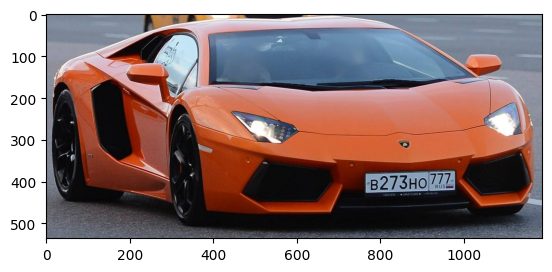

lamba


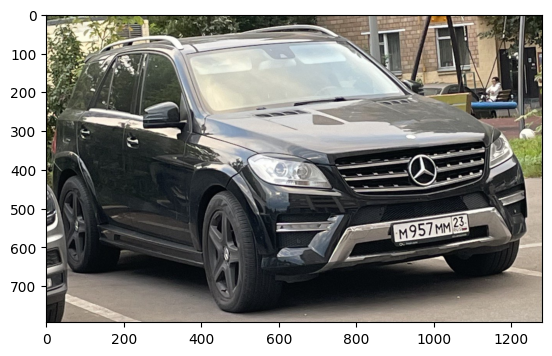

mercedes


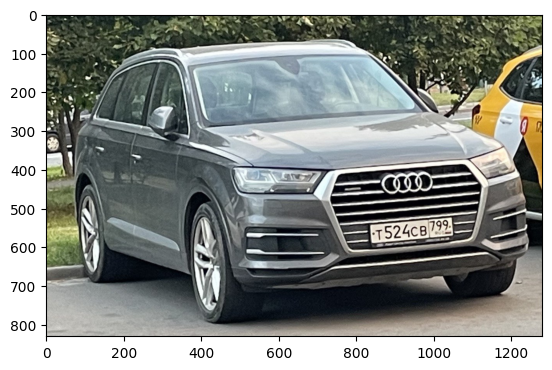

audi


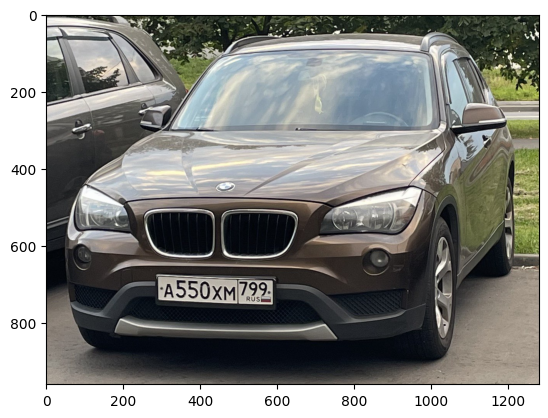

bmw


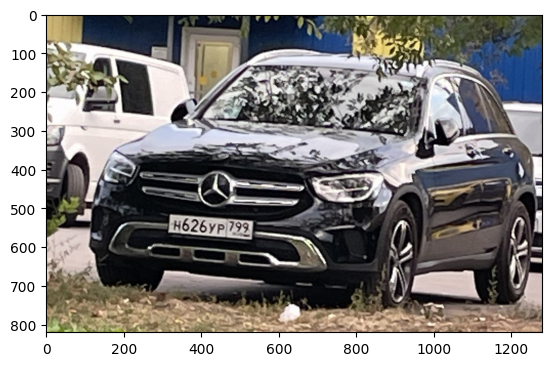

mercedes


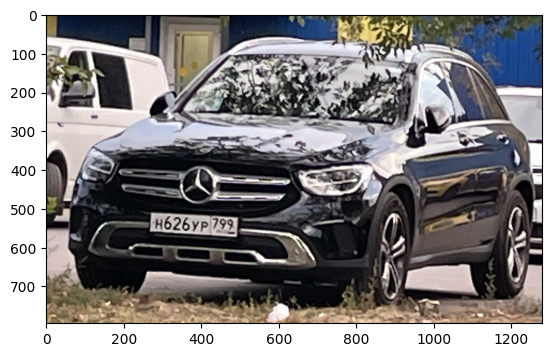

mercedes


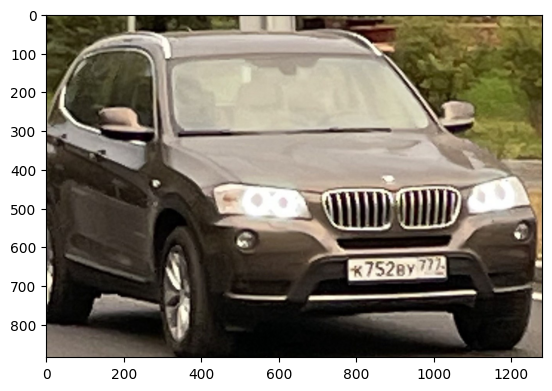

bmw


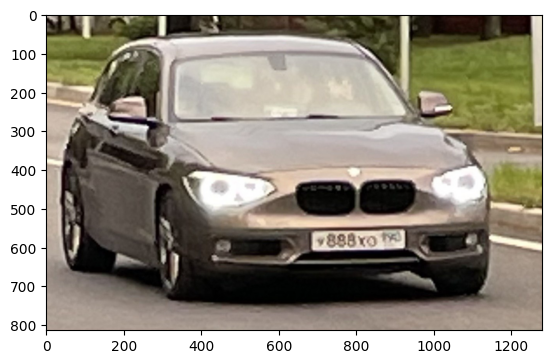

bmw


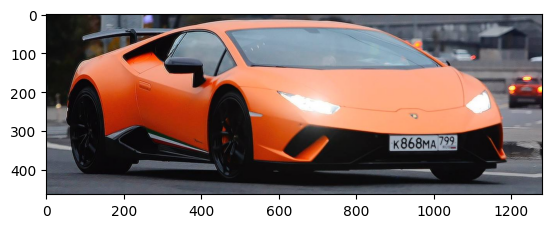

lamba


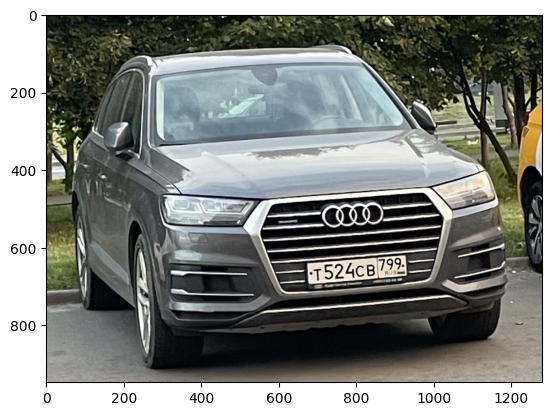

audi


In [266]:
for link in street_image_test:
    img = Image.open(link)
    plt.imshow(img)
    plt.show()
    class_image = pre_image(link, resnet_adam)
    print(class_image)
    
    
    